In [ ]:
# 📦 0. Instalación de dependencias
!pip install --upgrade pandas-gbq google-auth tensorflow scikit-learn joblib


In [ ]:
# 🔐 1. Autenticación GCP
from google.colab import auth
auth.authenticate_user()


In [ ]:
# 📥 2. Imports y configuración BigQuery
import pandas as pd
import numpy as np
from pandas_gbq import read_gbq
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
import joblib

PROJECT_ID    = "pokemon-cards-project"   # tu Project ID
BQ_DATASET    = "pokemon_dataset"
BQ_TABLE_META = "card_metadata"


In [ ]:
# 3️⃣ Carga de datos desde BigQuery
# Precios (todas las monthly_YYYY_MM_DD)
sql_prices = f"""
SELECT
  PARSE_DATE('%Y_%m_%d', _TABLE_SUFFIX) AS fecha,
  id                                    AS card_id,
  cm_averageSellPrice                   AS precio
FROM `{PROJECT_ID}.{BQ_DATASET}.monthly_*`
WHERE _TABLE_SUFFIX BETWEEN '2020_01_01'
  AND FORMAT_DATE('%Y_%m_%d', CURRENT_DATE())
ORDER BY card_id, fecha
"""
df_prices = read_gbq(sql_prices, project_id=PROJECT_ID)

# Metadatos (sin release_date)
sql_meta = f"""
SELECT
  id           AS card_id,
  artist       AS artist_name,
  name         AS pokemon_name,
  rarity,
  set_name,
  types,
  supertype,
  subtypes
FROM `{PROJECT_ID}.{BQ_DATASET}.{BQ_TABLE_META}`
"""
df_meta = read_gbq(sql_meta, project_id=PROJECT_ID)


Downloading: 100%|██████████|
Downloading: 100%|██████████|


In [ ]:
# 4️⃣ Diccionario de fechas de lanzamiento y merge
# 4.1 Define tu diccionario: set_name → release_date
release_dates = {'151': '2023/09/22',
 'Ancient Origins': '2015/08/12',
 'Aquapolis': '2003/01/15',
 'Arceus': '2009/11/04',
 'Astral Radiance': '2022/05/27',
 'Astral Radiance Trainer Gallery': '2022/05/27',
 'BREAKpoint': '2016/02/03',
 'BREAKthrough': '2015/11/04',
 'BW Black Star Promos': '2011/03/01',
 'Base': '1999/01/09',
 'Base Set 2': '2000/02/24',
 'Battle Styles': '2021/03/19',
 'Best of Game': '2002/12/01',
 'Black & White': '2011/04/25',
 'Boundaries Crossed': '2012/11/07',
 'Brilliant Stars': '2022/02/25',
 'Brilliant Stars Trainer Gallery': '2022/02/25',
 'Burning Shadows': '2017/08/05',
 'Call of Legends': '2011/02/09',
 'Celebrations': '2021/10/08',
 'Celebrations: Classic Collection': '2021/10/08',
 'Celestial Storm': '2018/08/03',
 "Champion's Path": '2020/09/25',
 'Chilling Reign': '2021/06/18',
 'Cosmic Eclipse': '2019/11/01',
 'Crimson Invasion': '2017/11/03',
 'Crown Zenith': '2023/01/20',
 'Crown Zenith Galarian Gallery': '2023/01/20',
 'Crystal Guardians': '2006/08/01',
 'DP Black Star Promos': '2007/05/01',
 'Dark Explorers': '2012/05/09',
 'Darkness Ablaze': '2020/08/14',
 'Delta Species': '2005/10/31',
 'Deoxys': '2005/02/01',
 'Detective Pikachu': '2019/04/05',
 'Diamond & Pearl': '2007/05/01',
 'Double Crisis': '2015/03/25',
 'Dragon': '2003/11/24',
 'Dragon Frontiers': '2006/11/01',
 'Dragon Majesty': '2018/09/07',
 'Dragon Vault': '2012/10/05',
 'Dragons Exalted': '2012/08/15',
 'EX Trainer Kit 2 Minun': '2006/03/01',
 'EX Trainer Kit 2 Plusle': '2006/03/01',
 'EX Trainer Kit Latias': '2004/06/01',
 'EX Trainer Kit Latios': '2004/06/01',
 'Emerald': '2005/05/01',
 'Emerging Powers': '2011/08/31',
 'Evolutions': '2016/11/02',
 'Evolving Skies': '2021/08/27',
 'Expedition Base Set': '2002/09/15',
 'Fates Collide': '2016/05/02',
 'FireRed & LeafGreen': '2004/09/01',
 'Flashfire': '2014/05/07',
 'Forbidden Light': '2018/05/04',
 'Fossil': '1999/10/10',
 'Furious Fists': '2014/08/13',
 'Fusion Strike': '2021/11/12',
 'Generations': '2016/02/22',
 'Great Encounters': '2008/02/01',
 'Guardians Rising': '2017/05/05',
 'Gym Challenge': '2000/10/16',
 'Gym Heroes': '2000/08/14',
 'HGSS Black Star Promos': '2010/02/10',
 'HS—Triumphant': '2010/11/03',
 'HS—Undaunted': '2010/08/18',
 'HS—Unleashed': '2010/05/12',
 'HeartGold & SoulSilver': '2010/02/10',
 'Hidden Fates': '2019/08/23',
 'Hidden Fates Shiny Vault': '2019/08/23',
 'Hidden Legends': '2004/06/01',
 'Holon Phantoms': '2006/05/01',
 'Journey Together': '2025/03/28',
 'Jungle': '1999/06/16',
 'Kalos Starter Set': '2013/11/08',
 'Legend Maker': '2006/02/01',
 'Legendary Collection': '2002/05/24',
 'Legendary Treasures': '2013/11/06',
 'Legends Awakened': '2008/08/01',
 'Lost Origin': '2022/09/09',
 'Lost Origin Trainer Gallery': '2022/09/09',
 'Lost Thunder': '2018/11/02',
 'Majestic Dawn': '2008/05/01',
 "McDonald's Collection 2011": '2011/06/17',
 "McDonald's Collection 2012": '2012/06/15',
 "McDonald's Collection 2014": '2014/05/23',
 "McDonald's Collection 2015": '2015/11/27',
 "McDonald's Collection 2016": '2016/08/19',
 "McDonald's Collection 2017": '2017/11/07',
 "McDonald's Collection 2018": '2018/10/16',
 "McDonald's Collection 2019": '2019/10/15',
 "McDonald's Collection 2021": '2021/02/09',
 "McDonald's Collection 2022": '2022/08/03',
 'Mysterious Treasures': '2007/08/01',
 'Neo Destiny': '2002/02/28',
 'Neo Discovery': '2001/06/01',
 'Neo Genesis': '2000/12/16',
 'Neo Revelation': '2001/09/21',
 'Next Destinies': '2012/02/08',
 'Nintendo Black Star Promos': '2003/10/01',
 'Noble Victories': '2011/11/16',
 'Obsidian Flames': '2023/08/11',
 'POP Series 1': '2004/09/01',
 'POP Series 2': '2005/08/01',
 'POP Series 3': '2006/04/01',
 'POP Series 4': '2006/08/01',
 'POP Series 5': '2007/03/01',
 'POP Series 6': '2007/09/01',
 'POP Series 7': '2008/03/01',
 'POP Series 8': '2008/09/01',
 'POP Series 9': '2009/03/01',
 'Paldea Evolved': '2023/06/09',
 'Paldean Fates': '2024/01/26',
 'Paradox Rift': '2023/11/03',
 'Phantom Forces': '2014/11/05',
 'Plasma Blast': '2013/08/14',
 'Plasma Freeze': '2013/05/08',
 'Plasma Storm': '2013/02/06',
 'Platinum': '2009/02/11',
 'Pokémon Futsal Collection': '2020/09/11',
 'Pokémon GO': '2022/07/01',
 'Pokémon Rumble': '2009/12/02',
 'Power Keepers': '2007/02/02',
 'Primal Clash': '2015/02/04',
 'Prismatic Evolutions': '2025/01/17',
 'Rebel Clash': '2020/05/01',
 'Rising Rivals': '2009/05/16',
 'Roaring Skies': '2015/05/06',
 'Ruby & Sapphire': '2003/07/01',
 'SM Black Star Promos': '2017/02/03',
 'SWSH Black Star Promos': '2019/11/15',
 'Sandstorm': '2003/09/18',
 'Scarlet & Violet': '2023/03/31',
 'Scarlet & Violet Black Star Promos': '2023/01/01',
 'Scarlet & Violet Energies': '2023/03/31',
 'Secret Wonders': '2007/11/01',
 'Shining Fates': '2021/02/19',
 'Shining Fates Shiny Vault': '2021/02/19',
 'Shining Legends': '2017/10/06',
 'Shrouded Fable': '2024/08/02',
 'Silver Tempest': '2022/11/11',
 'Silver Tempest Trainer Gallery': '2022/11/11',
 'Skyridge': '2003/05/12',
 'Southern Islands': '2001/07/31',
 'Steam Siege': '2016/08/03',
 'Stellar Crown': '2024/09/13',
 'Stormfront': '2008/11/01',
 'Sun & Moon': '2017/02/03',
 'Supreme Victors': '2009/08/19',
 'Surging Sparks': '2024/11/08',
 'Sword & Shield': '2020/02/07',
 'Team Magma vs Team Aqua': '2004/03/01',
 'Team Rocket': '2000/04/24',
 'Team Rocket Returns': '2004/11/01',
 'Team Up': '2019/02/01',
 'Temporal Forces': '2024/03/22',
 'Twilight Masquerade': '2024/05/24',
 'Ultra Prism': '2018/02/02',
 'Unbroken Bonds': '2019/05/03',
 'Unified Minds': '2019/08/02',
 'Unseen Forces': '2005/08/01',
 'Vivid Voltage': '2020/11/13',
 'Wizards Black Star Promos': '1999/07/01',
 'XY': '2014/02/05',
 'XY Black Star Promos': '2013/10/12'}


# 4.2 Convierte a DataFrame y parsea fechas
df_release = (
    pd.DataFrame.from_dict(release_dates, orient="index", columns=["release_date"])
      .reset_index()
      .rename(columns={"index":"set_name"})
)
df_release["release_date"] = pd.to_datetime(df_release["release_date"])

# 4.3 Merge con df_meta
df_meta = df_meta.merge(df_release, on="set_name", how="left")



In [ ]:
# 5️⃣ Merge, limpieza e imputación contextual
# 5.1 Merge precios + metadatos + release_date
df = df_prices.merge(df_meta, on="card_id", how="left")
df["fecha"] = pd.to_datetime(df["fecha"])
df = df.sort_values(["card_id","fecha"]).reset_index(drop=True)

# 5.2 Imputación de precios faltantes en 3 niveles + global
for grp in [("rarity","set_name"), ("pokemon_name",), ("artist_name",)]:
    df["precio"] = (
      df.groupby(["fecha"] + list(grp))["precio"]
        .transform(lambda x: x.fillna(x.median()))
    )
df["precio"] = df["precio"].fillna(df["precio"].median())

In [ ]:
# 7️⃣ Pipeline dinámico según nº de fechas disponibles

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.losses import Huber
from tensorflow.keras import Input, layers, Model

# 7.0 Definición de columnas y encoder para MLP (solo metadata)
cat_cols_meta = [
    "artist_name","pokemon_name","rarity",
    "set_name","types","supertype","subtypes"
]
ohe_meta = OneHotEncoder(sparse_output=False)
ohe_meta.fit(df_meta[cat_cols_meta])

# 7.1 Detectar cuántas fechas únicas hay
unique_dates = sorted(df_full["fecha"].unique())
n_dates      = len(unique_dates)
print(f"Fechas únicas: {n_dates} → {unique_dates}")

if n_dates == 2:
    # ─── PIPELINE A: MLP con log-transform, Huber Loss y sample weighting ───
    t0, t1 = unique_dates

    # 7A.1 Pivot wide
    df_wide = df_full.pivot(index="card_id", columns="fecha", values="precio").reset_index()
    df_wide.columns = ["card_id","price_t0","price_t1"]

    # 7A.2 Merge metadata esencial
    df_wide = df_wide.merge(df_meta[["card_id"] + cat_cols_meta], on="card_id", how="left")

    # 7A.3 Log-transform y days_diff
    df_wide["price_t0_log"] = np.log1p(df_wide["price_t0"])
    df_wide["price_t1_log"] = np.log1p(df_wide["price_t1"])
    df_wide["days_diff"]    = (t1 - t0).days

    # 7A.4 Escalado numérico
    scaler_mlp = StandardScaler()
    X_num = scaler_mlp.fit_transform(df_wide[["price_t0_log","days_diff"]])

    # 7A.5 Codificación categórica
    X_cat = ohe_meta.transform(df_wide[cat_cols_meta])

    # 7A.6 Montaje de X, y y pesos
    X       = np.hstack([X_num, X_cat])
    y       = df_wide["price_t1_log"].values
    weights = 1.0 / (1.0 + df_wide["price_t1"].values)

    # 7A.7 Train/test split con sample weights
    X_tr, X_val, y_tr, y_val, w_tr, w_val = train_test_split(
        X, y, weights, test_size=0.2, random_state=42
    )

    # 7A.8 Definición y compilación del MLP
    inp = Input(shape=(X.shape[1],), name="features")
    x   = layers.Dense(16, activation="relu")(inp)
    x   = layers.Dropout(0.3)(x)
    x   = layers.Dense(16, activation="relu")(x)
    x   = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation="linear")(x)

    model = Model(inp, out)
    model.compile(
        optimizer="adam",
        loss=Huber(delta=1.0),
        metrics=["mae"]
    )
    model.summary()

    # 7A.9 Entrenamiento con sample weights
    history = model.fit(
        X_tr, y_tr,
        sample_weight=w_tr,
        validation_data=(X_val, y_val, w_val),
        epochs=50,
        batch_size=32
    )

    # 7A.10 Evaluación en euros
    y_pred_log = model.predict(X_val).ravel()
    y_pred     = np.expm1(y_pred_log)
    y_true     = np.expm1(y_val)
    print("Val MAE (€):", mean_absolute_error(y_true, y_pred))

    # 7A.11 Guardado
    model.save("mlp_price_forecast.keras")
    joblib.dump(scaler_mlp, "scaler_mlp_num.pkl")
    joblib.dump(ohe_meta,   "ohe_mlp_cat.pkl")

else:
    # ─── PIPELINE B: LSTM time-series ─────────────────────────────
    SEQ_LEN   = n_dates - 1

    # 7B.1 Filtrar cartas con suficientes snapshots
    counts    = df_full.groupby("card_id")["fecha"].nunique()
    valid_ids = counts[counts >= SEQ_LEN+1].index
    df_ts     = df_full[df_full["card_id"].isin(valid_ids)].copy()

    # 7B.2 Construcción de secuencias
    def make_seq(g, L):
        Xs, Xm, ys = [], [], []
        for i in range(len(g)-L):
            seq_p = g["precio"].values[i:i+L]
            seq_d = g["days_since_prev"].values[i:i+L]
            Xs.append(np.stack([seq_p, seq_d], axis=-1))
            Xm.append(g[num_cols + list(cat_full_names)].iloc[i+L].values)
            ys.append(g["precio"].values[i+L])
        return np.array(Xs), np.array(Xm), np.array(ys)

    Xs, Xm, ys = [], [], []
    for _, grp in df_ts.groupby("card_id"):
        xi, xmi, yi = make_seq(grp, SEQ_LEN)
        if len(yi):
            Xs.append(xi); Xm.append(xmi); ys.append(yi)

    X_seq  = np.vstack(Xs)
    X_meta = np.vstack(Xm)
    y_all  = np.hstack(ys)

    # 7B.3 Train/test split
    X_seq_tr, X_seq_val, X_meta_tr, X_meta_val, y_tr, y_val = train_test_split(
        X_seq, X_meta, y_all, test_size=0.2, random_state=42
    )

    # 7B.4 Definición y entrenamiento del LSTM
    inp_seq  = Input(shape=(SEQ_LEN,2), name="serie_precios")
    inp_meta = Input(shape=(X_meta_tr.shape[1],), name="metadatos")
    x = layers.LSTM(16)(inp_seq)
    x = layers.Dropout(0.3)(x)
    x = layers.Concatenate()([x, inp_meta])
    x = layers.Dense(16, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation="linear")(x)

    model = Model([inp_seq, inp_meta], out)
    model.compile(optimizer="adam", loss="Huber", metrics=["mae"])
    model.summary()
    model.fit(
        {"serie_precios": X_seq_tr, "metadatos": X_meta_tr},
        y_tr,
        validation_data=(
            {"serie_precios": X_seq_val, "metadatos": X_meta_val},
            y_val
        ),
        epochs=50, batch_size=64
    )

    # 7B.5 Guardado de modelo y transformadores
    model.save("lstm_price_forecast.keras")
    joblib.dump(scaler_num,   "scaler_lstm_num.pkl")
    joblib.dump(ohe_full,     "ohe_lstm_cat.pkl")


Fechas únicas: 2 → [Timestamp('2025-04-01 00:00:00'), Timestamp('2025-04-30 00:00:00')]


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ features (InputLayer)           │ (None, 4865)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 16)             │        77,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,145 (305.25 KB)

 Trainable params: 78,145 (305.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0392 - mae: 0.5919 - val_loss: 0.0076 - val_mae: 0.2125
Epoch 2/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0143 - mae: 0.2904 - val_loss: 0.0064 - val_mae: 0.1991
Epoch 3/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0126 - mae: 0.2737 - val_loss: 0.0062 - val_mae: 0.1941
Epoch 4/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0110 - mae: 0.2577 - val_loss: 0.0060 - val_mae: 0.1914
Epoch 5/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0103 - mae: 0.2530 - val_loss: 0.0067 - val_mae: 0.2139
Epoch 6/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0098 - mae: 0.2514 - val_loss: 0.0060 - val_mae: 0.1920
Epoch 7/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0104 - mae: 0.2511 - val_loss: 0.0062 - val_mae: 0.1907
Epoch 8/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0096 - mae: 0.2450 - val_loss: 0.0060 - val_mae: 0.1906
Epoch 9/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - lo

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Predicciones sobre X_val
y_pred = model.predict(X_val).ravel()

print("Val MAE: ", mean_absolute_error(y_val, y_pred))
print("Val RMSE:", np.sqrt(mean_squared_error(y_val, y_pred)))


118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Val MAE:  0.19691177412159733
Val RMSE: 0.3340857924992235


118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


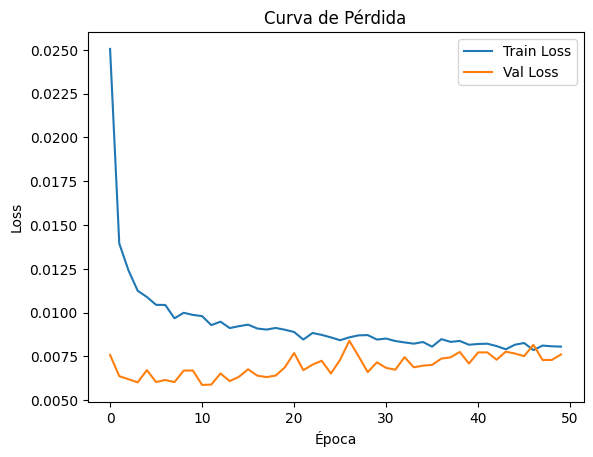

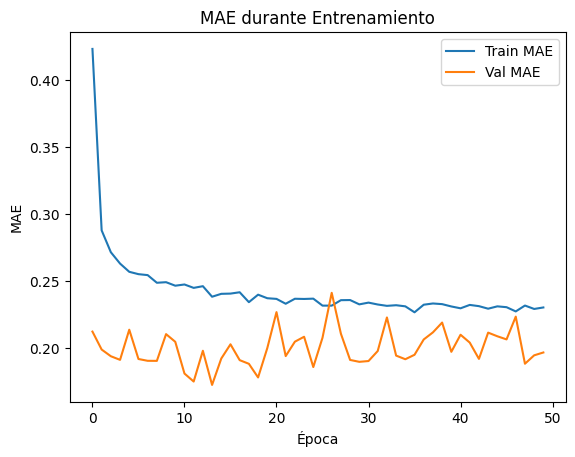

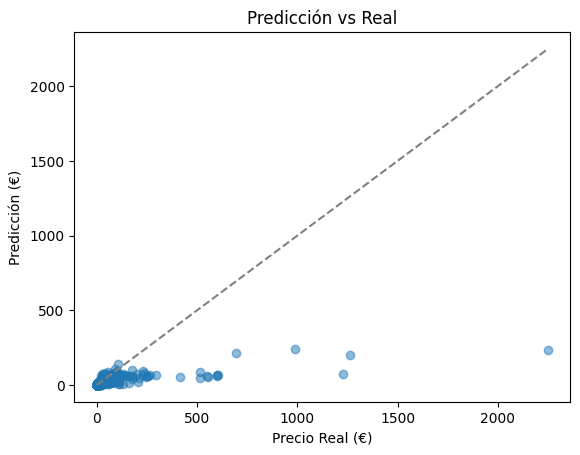

Val MAE (€): 5.182535822162389


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error

# Asegúrate de tener estas variables definidas en el mismo scope:
#   history, model, X_val, y_val

# Reconstruir valores en euros (deshaciendo log1p)
y_true_eur = np.expm1(y_val)
y_pred_log = model.predict(X_val).ravel()
y_pred_eur = np.expm1(y_pred_log)

# 1. Curva de Pérdida
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Curva de Pérdida')
plt.legend()
plt.show()

# 2. Curva de MAE
plt.figure()
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.title('MAE durante Entrenamiento')
plt.legend()
plt.show()

# 3. Predicción vs Real
plt.figure()
plt.scatter(y_true_eur, y_pred_eur, alpha=0.5)
m, M = min(y_true_eur.min(), y_pred_eur.min()), max(y_true_eur.max(), y_pred_eur.max())
plt.plot([m, M], [m, M], color='gray', linestyle='--')
plt.xlabel('Precio Real (€)')
plt.ylabel('Predicción (€)')
plt.title('Predicción vs Real')
plt.show()

# 4. MAE Final en euros
print("Val MAE (€):", mean_absolute_error(y_true_eur, y_pred_eur))


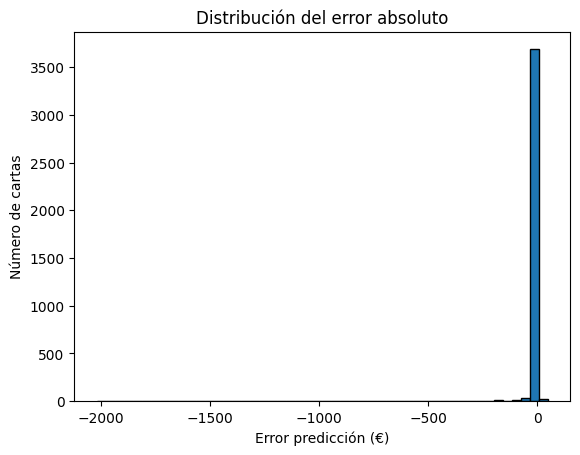

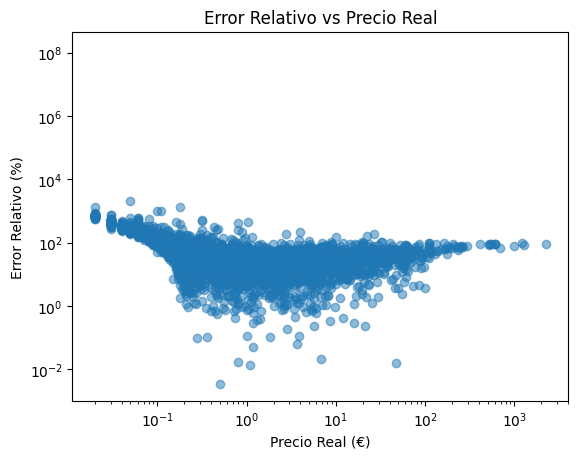

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1) Histograma de errores absolutos en euros
residuals = y_pred_eur - y_true_eur
plt.figure()
plt.hist(residuals, bins=50, edgecolor='k')
plt.xlabel('Error predicción (€)')
plt.ylabel('Número de cartas')
plt.title('Distribución del error absoluto')
plt.show()

# 2) Error relativo (%) vs Precio real
rel_error = np.abs(residuals) / (y_true_eur + 1e-6) * 100
plt.figure()
plt.scatter(y_true_eur, rel_error, alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Precio Real (€)')
plt.ylabel('Error Relativo (%)')
plt.title('Error Relativo vs Precio Real')
plt.show()


Percentiles de error absoluto (€/carta):
  50 % ≤ 0.15 €
  75 % ≤ 0.85 €
  90 % ≤ 4.39 €
  95 % ≤ 11.94 €
  99 % ≤ 72.03 €


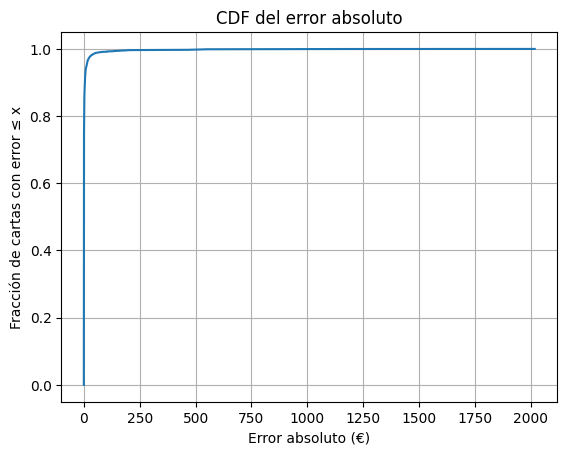

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# residuals = y_pred_eur - y_true_eur (creados en el bloque anterior)
res = np.abs(residuals)

# calcula percentiles
pct = np.percentile(res, [50, 75, 90, 95, 99])
print("Percentiles de error absoluto (€/carta):")
for q, val in zip([50,75,90,95,99], pct):
    print(f"  {q} % ≤ {val:.2f} €")

# dibuja la CDF
sorted_r = np.sort(res)
cdf = np.arange(len(res)) / len(res)
plt.figure()
plt.plot(sorted_r, cdf)
plt.xlabel('Error absoluto (€)')
plt.ylabel('Fracción de cartas con error ≤ x')
plt.title('CDF del error absoluto')
plt.grid(True)
plt.show()


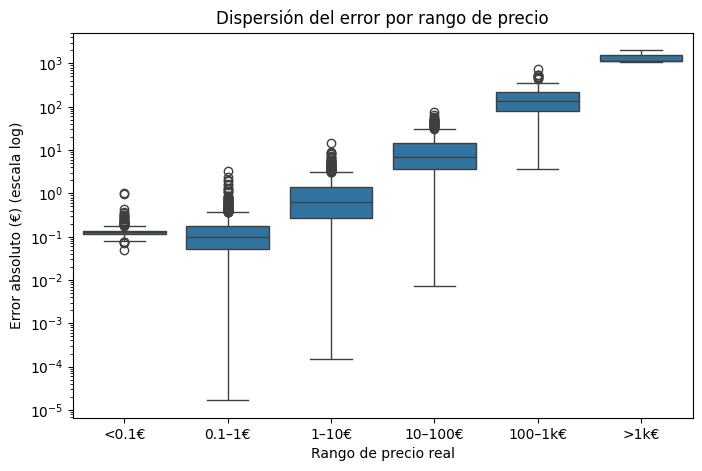

In [ ]:
import pandas as pd
import seaborn as sns

df_err = pd.DataFrame({
    'precio': y_true_eur,
    'error':  np.abs(residuals)
})
# crear categorías de precio en escala log
df_err['bin'] = pd.cut(df_err['precio'],
                       bins=[0,0.1,1,10,100,1000,1e5],
                       labels=['<0.1€','0.1–1€','1–10€','10–100€','100–1k€','>1k€'])

plt.figure(figsize=(8,5))
sns.boxplot(x='bin', y='error', data=df_err)
plt.yscale('log')
plt.xlabel('Rango de precio real')
plt.ylabel('Error absoluto (€) (escala log)')
plt.title('Dispersión del error por rango de precio')
plt.show()


In [ ]:
# 1️⃣ Montar tu Google Drive en Colab
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:

# ▶️ Definir ruta de destino en tu Drive
drive_base = "/content/drive/MyDrive/Proyecto API/RedNeuronal/mlp_v1"
import os
os.makedirs(drive_base, exist_ok=True)

# ▶️ Guardar el modelo en formato SavedModel
import tensorflow as tf
tf.saved_model.save(model, drive_base)

# ▶️ Guardar también tus transformadores
import joblib
joblib.dump(scaler_mlp, os.path.join(drive_base, "scaler_mlp_num.pkl"))
joblib.dump(ohe_meta,   os.path.join(drive_base, "ohe_mlp_cat.pkl"))

print(f"✅ Modelo SavedModel y transformadores guardados en: {drive_base}")


✅ Modelo SavedModel y transformadores guardados en: /content/drive/MyDrive/Proyecto API/RedNeuronal/mlp_v1


In [ ]:

# Celda 2: Ejecutar saved_model_cli apuntando a la ruta correcta en Drive

# La ruta donde guardaste tu SavedModel, según tu script de guardado
path_to_saved_model_on_drive = '/content/drive/MyDrive/Proyecto API/RedNeuronal/mlp_v1'

# Verificar que la ruta y el archivo saved_model.pb existen
import os
if os.path.exists(os.path.join(path_to_saved_model_on_drive, "saved_model.pb")):
    print(f"Ejecutando saved_model_cli para el directorio en Drive: {path_to_saved_model_on_drive}")
    # Usamos llaves {} para pasar la variable de Python al comando de shell
    # y comillas para manejar posibles espacios en la ruta.
    !saved_model_cli show --dir "{path_to_saved_model_on_drive}" --all
else:
    print(f"Error: No se encontró 'saved_model.pb' en la ruta especificada: '{path_to_saved_model_on_drive}'.")
    print("Por favor, verifica lo siguiente:")
    print("1. Que Google Drive se haya montado correctamente (ejecuta la Celda 1 primero).")
    print(f"2. Que la ruta '{path_to_saved_model_on_drive}' sea exactamente donde se encuentra la carpeta 'mlp_v1' que contiene 'saved_model.pb'.")
    print("   Puedes navegar por el panel de Archivos de Colab (izquierda) para confirmar la ruta después de montar Drive.")

Ejecutando saved_model_cli para el directorio en Drive: /content/drive/MyDrive/Proyecto API/RedNeuronal/mlp_v1
2025-05-06 17:30:02.764401: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746552602.800517    1202 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746552602.811290    1202 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-06 17:30:02.847581: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-06 17:

In [4]:
import joblib
import os
import pandas as pd # Lo necesitaremos para crear un DataFrame de ejemplo

# --- PASO 1: Define la ruta a tus archivos .pkl ---
# Ajusta esta ruta si es diferente.
# Esta es la ruta que usaste para guardar, así que debería ser correcta si estás en el mismo entorno
# o has montado Drive de la misma manera.
base_model_path = '/content/drive/MyDrive/Proyecto API/RedNeuronal/mlp_v1' # Para Colab con Drive montado
# Si estás en local y los archivos están en, por ejemplo, 'C:\modelos\mlp_v1':
# base_model_path = 'C:/modelos/mlp_v1' # Ajusta según tu sistema

scaler_path = os.path.join(base_model_path, "scaler_mlp_num.pkl")
ohe_path = os.path.join(base_model_path, "ohe_mlp_cat.pkl")

print(f"Intentando cargar Scaler desde: {scaler_path}")
print(f"Intentando cargar OneHotEncoder desde: {ohe_path}\n")

# --- PASO 2: Cargar los preprocesadores ---
try:
    scaler = joblib.load(scaler_path)
    print(f"✅ Scaler cargado exitosamente.")
    print(f"   Tipo de Scaler: {type(scaler)}")
except FileNotFoundError:
    print(f"❌ ERROR: No se encontró el archivo del Scaler en '{scaler_path}'. Verifica la ruta.")
    scaler = None
except Exception as e:
    print(f"❌ ERROR al cargar el Scaler: {e}")
    scaler = None

try:
    ohe = joblib.load(ohe_path)
    print(f"\n✅ OneHotEncoder cargado exitosamente.")
    print(f"   Tipo de OneHotEncoder: {type(ohe)}")
except FileNotFoundError:
    print(f"❌ ERROR: No se encontró el archivo del OneHotEncoder en '{ohe_path}'. Verifica la ruta.")
    ohe = None
except Exception as e:
    print(f"❌ ERROR al cargar el OneHotEncoder: {e}")
    ohe = None

print("\n--- Información del Scaler (si se cargó) ---")
if scaler:
    try:
        # Para la mayoría de los scalers de scikit-learn
        print(f"   Características numéricas que el Scaler espera (n_features_in_): {scaler.n_features_in_}")
        if hasattr(scaler, 'feature_names_in_'):
            print(f"   Nombres de las características numéricas vistas durante fit: {list(scaler.feature_names_in_)}")
            # ESTA LISTA ES LA QUE NECESITAS PARA _NUMERICAL_COLS_FOR_MODEL_PREPROCESSING
        else:
            print("   El Scaler no tiene el atributo 'feature_names_in_'. Esto es común si se entrenó con arrays NumPy sin nombres de columnas.")
            print("   En este caso, el ORDEN de las columnas numéricas es crucial, y n_features_in_ te dice cuántas eran.")

        # Otras propiedades útiles (varían según el tipo de scaler)
        if hasattr(scaler, 'mean_'):
            print(f"   Medias aprendidas (mean_): {scaler.mean_}")
        if hasattr(scaler, 'scale_'):
            print(f"   Escalas aprendidas (scale_): {scaler.scale_}")

    except AttributeError as e:
        print(f"   No se pudo acceder a alguna propiedad del Scaler: {e}")
    except Exception as e:
        print(f"   Error inspeccionando el Scaler: {e}")
else:
    print("   Scaler no cargado.")


print("\n--- Información del OneHotEncoder (si se cargó) ---")
if ohe:
    try:
        print(f"   Características categóricas que el OHE espera (n_features_in_): {ohe.n_features_in_}") # Número de columnas originales

        if hasattr(ohe, 'feature_names_in_'):
            print(f"   Nombres de las características categóricas originales vistas durante fit: {list(ohe.feature_names_in_)}")
            # ESTA LISTA ES LA QUE NECESITAS PARA _CATEGORICAL_COLS_FOR_MODEL_PREPROCESSING
        else:
            print("   El OHE no tiene el atributo 'feature_names_in_'. Esto es común si se entrenó con arrays NumPy sin nombres de columnas.")
            print("   En este caso, el ORDEN de las columnas categóricas es crucial.")

        # Los nombres de las características generadas después del OHE son importantes para saber el número total de features
        if hasattr(ohe, 'get_feature_names_out'):
            # Si feature_names_in_ está disponible, úsalo. Sino, se puede intentar sin él, pero es menos informativo.
            input_features_for_ohe_names = None
            if hasattr(ohe, 'feature_names_in_'):
                input_features_for_ohe_names = ohe.feature_names_in_

            generated_feature_names = ohe.get_feature_names_out(input_features=input_features_for_ohe_names)
            print(f"   Nombres de las características generadas por OHE (get_feature_names_out): {list(generated_feature_names)}")
            print(f"   Número de características generadas por OHE: {len(generated_feature_names)}")
            # ESTE NÚMERO, SUMADO AL NÚMERO DE CARACTERÍSTICAS NUMÉRICAS, DEBERÍA DAR 4865
        elif hasattr(ohe, 'categories_'):
            # Forma alternativa de estimar el número de columnas generadas si get_feature_names_out no está
            num_generated_cols = sum(len(cat_array) for cat_array in ohe.categories_)
            print(f"   Número estimado de características generadas por OHE (basado en categories_): {num_generated_cols}")
            print(f"   Categorías aprendidas por columna (categories_):")
            if hasattr(ohe, 'feature_names_in_'):
                 for i, col_name in enumerate(ohe.feature_names_in_):
                    print(f"     - Columna '{col_name}': {list(ohe.categories_[i])}")
            else:
                for i, cat_array in enumerate(ohe.categories_):
                    print(f"     - Columna original {i}: {list(cat_array)}")
        else:
            print("   No se pudo determinar el número de características generadas por OHE (faltan get_feature_names_out y categories_).")

    except AttributeError as e:
        print(f"   No se pudo acceder a alguna propiedad del OHE: {e}")
    except Exception as e:
        print(f"   Error inspeccionando el OHE: {e}")
else:
    print("   OneHotEncoder no cargado.")

print("\n--- Verificación de la suma de características ---")
num_scaled_features = 0
num_ohe_generated_features = 0

if scaler and hasattr(scaler, 'n_features_in_'):
    num_scaled_features = scaler.n_features_in_ # Esto es el número de columnas ANTES de escalar
    # Si feature_names_in_ existe, es más preciso.
    if hasattr(scaler, 'feature_names_in_'):
        num_scaled_features = len(scaler.feature_names_in_)

if ohe:
    if hasattr(ohe, 'get_feature_names_out'):
        input_features_for_ohe_names = ohe.feature_names_in_ if hasattr(ohe, 'feature_names_in_') else None
        num_ohe_generated_features = len(ohe.get_feature_names_out(input_features=input_features_for_ohe_names))
    elif hasattr(ohe, 'categories_'):
        num_ohe_generated_features = sum(len(cat_array) for cat_array in ohe.categories_)

if scaler and ohe:
    total_features_for_model = num_scaled_features + num_ohe_generated_features
    print(f"\nNúmero de características numéricas (después de escalar, igual que antes): {num_scaled_features}")
    print(f"Número de características categóricas (después de OHE): {num_ohe_generated_features}")
    print(f"SUMA TOTAL DE CARACTERÍSTICAS CALCULADA: {total_features_for_model}")
    print(f"MODELO TF ESPERA (según saved_model_cli): 4865")
    if total_features_for_model == 4865:
        print("✅ ¡La suma de características COINCIDE con lo esperado por el modelo TensorFlow!")
    else:
        print("❌ ¡DESAJUSTE! La suma de características calculada NO COINCIDE con las 4865 esperadas por el modelo TensorFlow.")
        print("   Revisa los nombres y el número de columnas que alimentan al Scaler y al OHE.")
elif scaler:
    print(f"\nNúmero de características numéricas: {num_scaled_features}")
    print("   OHE no cargado, no se puede calcular suma total.")
elif ohe:
    print(f"\nNúmero de características generadas por OHE: {num_ohe_generated_features}")
    print("   Scaler no cargado, no se puede calcular suma total.")
else:
    print("\nNi Scaler ni OHE cargados, no se puede verificar la suma de características.")

Intentando cargar Scaler desde: /content/drive/MyDrive/Proyecto API/RedNeuronal/mlp_v1/scaler_mlp_num.pkl
Intentando cargar OneHotEncoder desde: /content/drive/MyDrive/Proyecto API/RedNeuronal/mlp_v1/ohe_mlp_cat.pkl

✅ Scaler cargado exitosamente.
   Tipo de Scaler: <class 'sklearn.preprocessing._data.StandardScaler'>

✅ OneHotEncoder cargado exitosamente.
   Tipo de OneHotEncoder: <class 'sklearn.preprocessing._encoders.OneHotEncoder'>

--- Información del Scaler (si se cargó) ---
   Características numéricas que el Scaler espera (n_features_in_): 2
   Nombres de las características numéricas vistas durante fit: ['price_t0_log', 'days_diff']
   Medias aprendidas (mean_): [ 0.98452049 29.        ]
   Escalas aprendidas (scale_): [1.1262126 1.       ]

--- Información del OneHotEncoder (si se cargó) ---
   Características categóricas que el OHE espera (n_features_in_): 7
   Nombres de las características categóricas originales vistas durante fit: ['artist_name', 'pokemon_name', 'rarity'